## Imports

In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from collections import Counter

C:\Users\karim\anaconda3\envs\my_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Images

In [2]:
folder_path = "Train/"
image_dataset = datasets.ImageFolder(root=folder_path)

In [3]:
len(image_dataset)

4200

#### The training set has 700 images for 6 different classes which equals a total of 4200 images for the training set

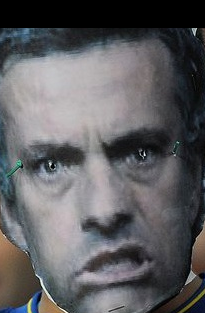

In [4]:
image_dataset[1000][0]  ## Viewing a Sample image

In [5]:
image_dimensions = []

for img, _ in image_dataset:
    img_shape = np.array(img).squeeze().shape
    image_dimensions.append(img_shape)

dimension_counter = Counter(image_dimensions)

avg_h = 0
avg_w = 0

for dim, _ in dimension_counter.items():
    avg_h += dim[0]
    avg_w += dim[1]    

In [6]:
avg_h/len(image_dataset), avg_w/len(image_dataset)

(360.9695238095238, 281.17333333333335)

#### The average dimensions of the 4200 images is approximately 361x281. We will use 300x300 for standardizing the dimensions of all images.

## Pre-Processing

#### Standardizing dimensions to 300x300 + Converting to Grayscale + Applying Normalization 

In [7]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),        
    transforms.Normalize(0, 1)
])

image_dataset = datasets.ImageFolder(root=folder_path, transform=transform)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [8]:
train_loader = DataLoader(
    dataset=image_dataset,
    batch_size=32, 
    shuffle=True,  
    num_workers=4  
)

#### 6 Different Classes with 700 images for each

In [9]:
image_dataset.classes

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

#### Labeled Random Samples

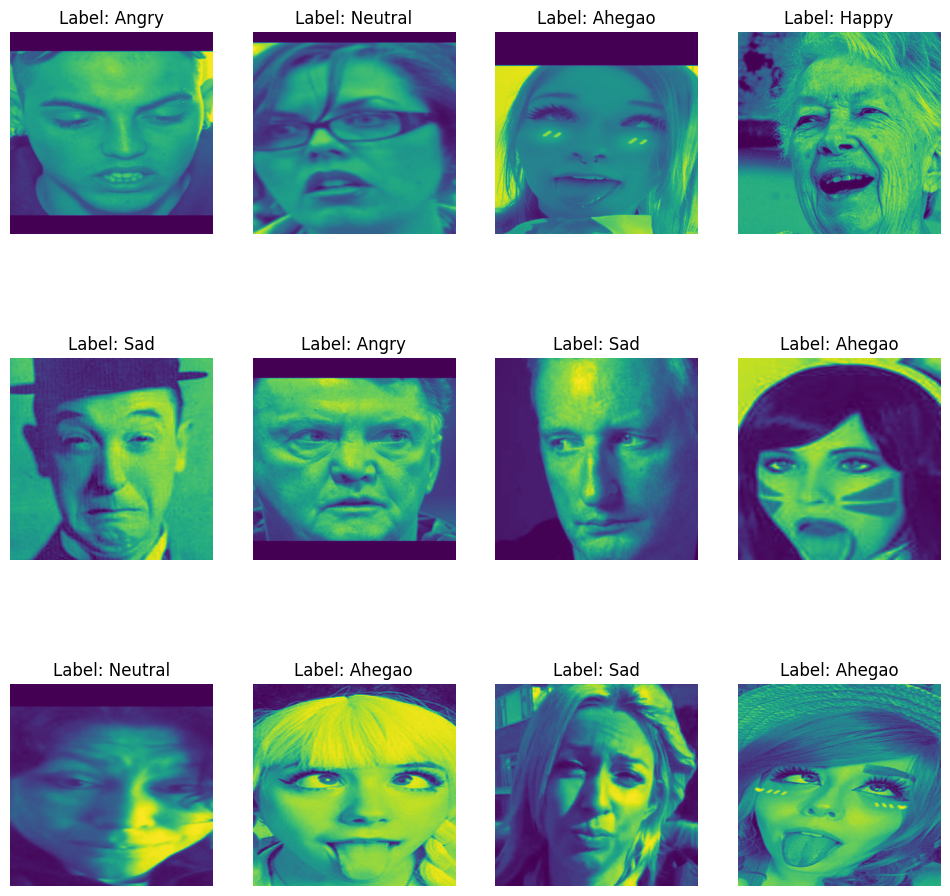

In [10]:
train_iter = iter(train_loader)
images, labels = next(train_iter)

plt.figure(figsize=(12, 12))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].permute(1, 2, 0))  
    plt.title(f"Label: {image_dataset.classes[labels[i]]}")
    plt.axis("off")
plt.show()

# ------------------------------------------------------------------------------------------

## Vision Transformer

### Step 1: Patchifying each image.

In [11]:
patch_size = 15
channels = 1
img_size = 300
embed_dim = (patch_size ** 2) * channels  #225
num_of_patches = int((img_size / patch_size) ** 2)  #400

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),                  
            nn.Flatten(2))

        self.class_token = nn.Parameter(torch.randn(size=(1, 1, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)

    def forward(self, x):
        class_token = self.class_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([class_token, x], dim=1)
        x = self.position_embeddings + x 
        
        return x

### Step 2: Vision Transformer Model

In [13]:
num_classes = 6
num_of_heads = 5
num_of_encoders = 4

In [14]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, channels)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, activation="gelu", batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

### Step 3: Training

In [15]:
vit_model = ViT(num_of_patches, img_size, num_classes, patch_size, embed_dim, num_of_encoders, num_of_heads,channels).to(device)
vit_model.to(device)

C:\Users\karim\anaconda3\envs\my_env\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ViT(
  (embeddings_block): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 225, kernel_size=(15, 15), stride=(15, 15))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
  )
  (encoder_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=225, out_features=225, bias=True)
        )
        (linear1): Linear(in_features=225, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=225, bias=True)
        (norm1): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
    (1):

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model.parameters(), lr=0.001)
epochs = 50

save_name = 'vit_model.pth'

epochs_loss = []
training_accuracies = []


for epoch in range(epochs):
    vit_model.train()
    tot_loss = 0
    correct = 0
    
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        y_pred = vit_model(img)
        y_pred_label = y_pred.argmax(dim=1)

        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()

        correct += (y_pred_label == label).sum().item()
        
    epochs_loss.append(tot_loss)
    training_accuracies.append(correct / 4200)
    print(f'Epoch {epoch+1} total loss = {tot_loss}')
    print(f'Epoch {epoch+1} accuracy = {correct / 4200}')
    correct = 0
    tot_loss = 0
    torch.save(vit_model.state_dict(), save_name)

C:\Users\karim\anaconda3\envs\my_env\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1 total loss = 240.11480164527893
Epoch 1 accuracy = 0.20547619047619048
Epoch 2 total loss = 221.88359677791595
Epoch 2 accuracy = 0.2764285714285714
Epoch 3 total loss = 212.78288900852203
Epoch 3 accuracy = 0.31
Epoch 4 total loss = 207.46559882164001
Epoch 4 accuracy = 0.33285714285714285
Epoch 5 total loss = 201.71013987064362
Epoch 5 accuracy = 0.3495238095238095
Epoch 6 total loss = 198.73102247714996
Epoch 6 accuracy = 0.36333333333333334
Epoch 7 total loss = 194.70244300365448
Epoch 7 accuracy = 0.37833333333333335
Epoch 8 total loss = 196.2620953321457
Epoch 8 accuracy = 0.3761904761904762
Epoch 9 total loss = 192.03918719291687
Epoch 9 accuracy = 0.3952380952380952
Epoch 10 total loss = 188.28936684131622
Epoch 10 accuracy = 0.41023809523809524
Epoch 11 total loss = 187.39769995212555
Epoch 11 accuracy = 0.4080952380952381
Epoch 12 total loss = 187.07566261291504
Epoch 12 accuracy = 0.40595238095238095
Epoch 13 total loss = 184.24417173862457
Epoch 13 accuracy = 0.4219

### Step 4: Testing

In [17]:
test_folder = 'Test/'
test_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=32, 
    shuffle=True,  
    num_workers=4  
)

In [18]:
vit_model.eval()

all_labels = [    ]
all_predictions = [    ]

with torch.no_grad():
    for img, labels in test_loader:
        img = img.to(device)
        lables = labels.to(device)
        outputs = vit_model(img)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy on test dataset: {accuracy * 100:.2f}%')

Accuracy on test dataset: 37.39%


## Evaluation

#### Confusion Matrix

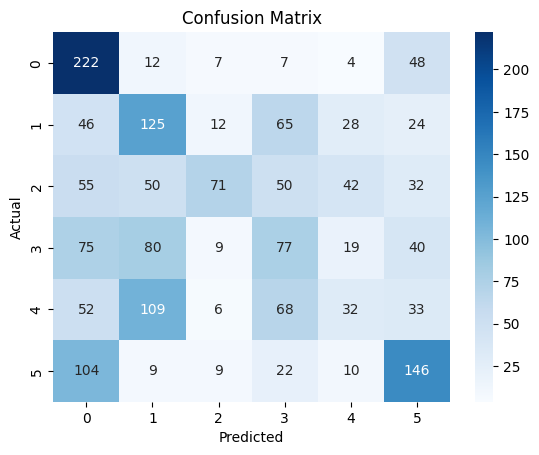

Number of misclassified examples: 1127


In [19]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

misclassified_indices = np.where(np.array(all_labels) != np.array(all_predictions))[0]
print(f'Number of misclassified examples: {len(misclassified_indices)}')

#### Classification Report

In [20]:
report = classification_report(all_labels, all_predictions, target_names=test_dataset.classes)
print(report)

              precision    recall  f1-score   support

      Ahegao       0.40      0.74      0.52       300
       Angry       0.32      0.42      0.36       300
       Happy       0.62      0.24      0.34       300
     Neutral       0.27      0.26      0.26       300
         Sad       0.24      0.11      0.15       300
    Surprise       0.45      0.49      0.47       300

    accuracy                           0.37      1800
   macro avg       0.38      0.37      0.35      1800
weighted avg       0.38      0.37      0.35      1800



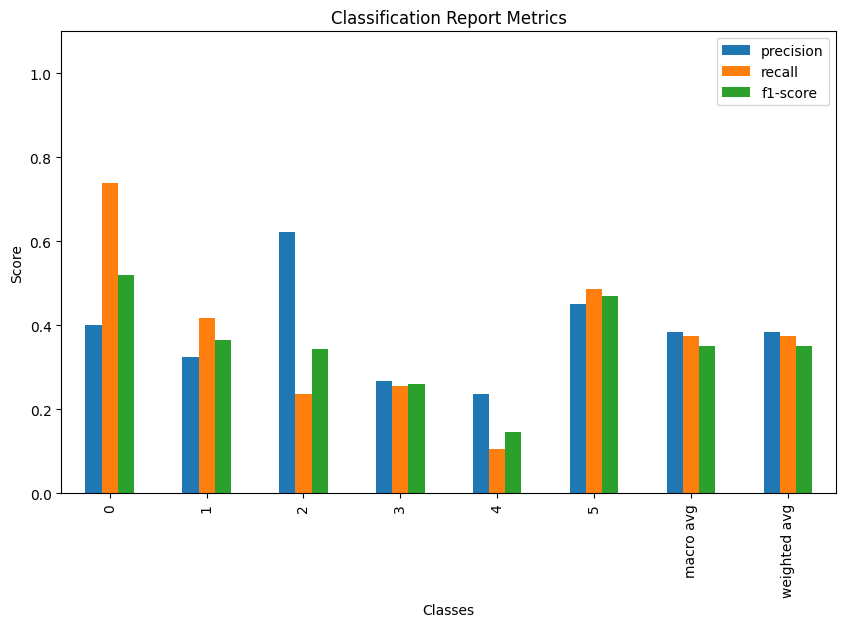

In [21]:
v_report = classification_report(all_labels, all_predictions, output_dict=True)

df = pd.DataFrame(v_report).transpose()
metrics = ['precision', 'recall', 'f1-score']
plt.figure(figsize=(10, 6))
df.loc[df.index != 'accuracy', metrics].plot(kind='bar', ax=plt.gca())
plt.title("Classification Report Metrics")
plt.xlabel("Classes")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.show()

#### Training Learning Curve

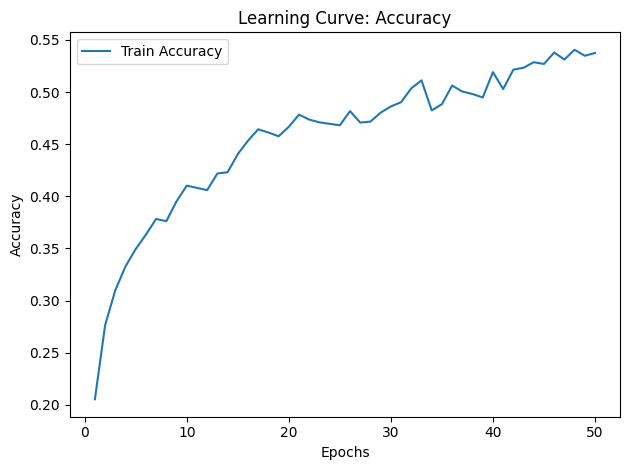

In [22]:
plt.plot(range(1, epochs + 1), training_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Vision Transformer Variation 2

#### Same Everything but larger number of heads.

In [23]:
heads_num = 9

In [24]:
vit_model2 = ViT(num_of_patches, img_size, num_classes, patch_size, embed_dim, num_of_encoders, heads_num, channels).to(device)
vit_model2.to(device)

C:\Users\karim\anaconda3\envs\my_env\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ViT(
  (embeddings_block): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 225, kernel_size=(15, 15), stride=(15, 15))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
  )
  (encoder_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=225, out_features=225, bias=True)
        )
        (linear1): Linear(in_features=225, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=225, bias=True)
        (norm1): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
    (1):

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit_model2.parameters(), lr=0.001)
epochs = 50

save_name = 'vit_model2.pth'

epochs_loss = []
training_accuracies = []


for epoch in range(epochs):
    vit_model2.train()
    tot_loss = 0
    correct = 0
    
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        y_pred = vit_model2(img)
        y_pred_label = y_pred.argmax(dim=1)

        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()

        correct += (y_pred_label == label).sum().item()
        
    epochs_loss.append(tot_loss)
    training_accuracies.append(correct / 4200)
    print(f'Epoch {epoch+1} total loss = {tot_loss}')
    print(f'Epoch {epoch+1} accuracy = {correct / 4200}')
    correct = 0
    tot_loss = 0
    torch.save(vit_model2.state_dict(), save_name)

Epoch 1 total loss = 242.7093071937561
Epoch 1 accuracy = 0.20214285714285715
Epoch 2 total loss = 216.27775955200195
Epoch 2 accuracy = 0.3092857142857143
Epoch 3 total loss = 208.53603148460388
Epoch 3 accuracy = 0.34833333333333333
Epoch 4 total loss = 202.55125892162323
Epoch 4 accuracy = 0.36857142857142855
Epoch 5 total loss = 197.6587713956833
Epoch 5 accuracy = 0.3761904761904762
Epoch 6 total loss = 189.10965859889984
Epoch 6 accuracy = 0.40404761904761904
Epoch 7 total loss = 186.58663046360016
Epoch 7 accuracy = 0.4104761904761905
Epoch 8 total loss = 180.35775065422058
Epoch 8 accuracy = 0.44047619047619047
Epoch 9 total loss = 176.4945968389511
Epoch 9 accuracy = 0.4392857142857143
Epoch 10 total loss = 175.52777689695358
Epoch 10 accuracy = 0.4483333333333333
Epoch 11 total loss = 169.90145736932755
Epoch 11 accuracy = 0.47333333333333333
Epoch 12 total loss = 166.52942913770676
Epoch 12 accuracy = 0.48095238095238096
Epoch 13 total loss = 164.87437015771866
Epoch 13 accu

In [26]:
vit_model2.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for img, labels in test_loader:
        img = img.to(device)
        lables = labels.to(device)
        outputs = vit_model2(img)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy on test dataset: {accuracy * 100:.2f}%')

Accuracy on test dataset: 36.22%


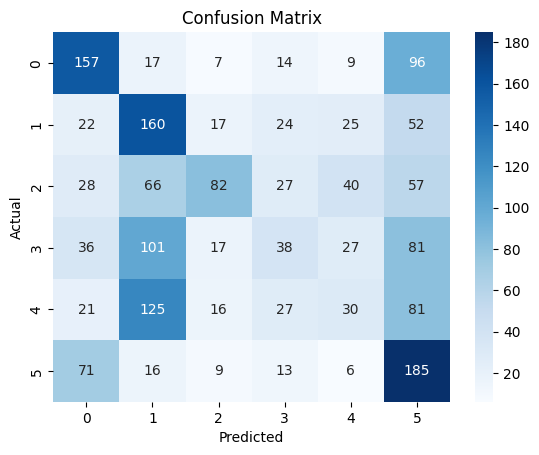

Number of misclassified examples: 1148


In [27]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

misclassified_indices = np.where(np.array(all_labels) != np.array(all_predictions))[0]
print(f'Number of misclassified examples: {len(misclassified_indices)}')

In [28]:
report2 = classification_report(all_labels, all_predictions, target_names=test_dataset.classes)
print(report2)

              precision    recall  f1-score   support

      Ahegao       0.47      0.52      0.49       300
       Angry       0.33      0.53      0.41       300
       Happy       0.55      0.27      0.37       300
     Neutral       0.27      0.13      0.17       300
         Sad       0.22      0.10      0.14       300
    Surprise       0.34      0.62      0.43       300

    accuracy                           0.36      1800
   macro avg       0.36      0.36      0.34      1800
weighted avg       0.36      0.36      0.34      1800



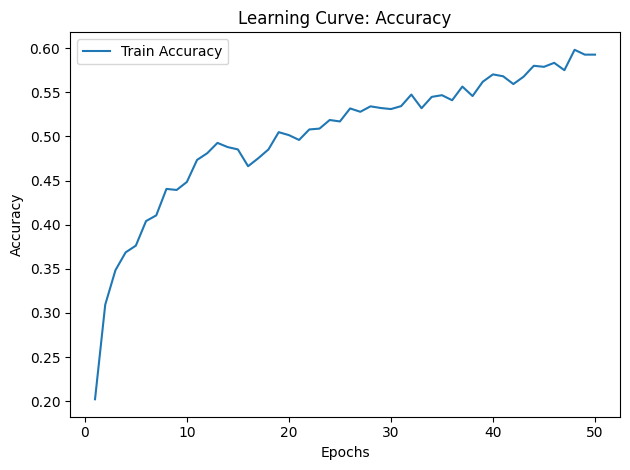

In [29]:
plt.plot(range(1, epochs + 1), training_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Vision Transformer Variation 3

#### Same Everything as Variation 2 but with Stochastic Gradient Descent Optimizer instead of ADAM.

In [30]:
vit_model3 = ViT(num_of_patches, img_size, num_classes, patch_size, embed_dim, num_of_encoders, heads_num, channels).to(device)
vit_model3.to(device)

C:\Users\karim\anaconda3\envs\my_env\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


ViT(
  (embeddings_block): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 225, kernel_size=(15, 15), stride=(15, 15))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
  )
  (encoder_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=225, out_features=225, bias=True)
        )
        (linear1): Linear(in_features=225, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=225, bias=True)
        (norm1): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
    (1):

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vit_model3.parameters(), lr=0.001, momentum=0.9)
epochs = 50

save_name = 'vit_model3.pth'

epochs_loss = []
training_accuracies = []


for epoch in range(epochs):
    vit_model3.train()
    tot_loss = 0
    correct = 0
    
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        y_pred = vit_model3(img)
        y_pred_label = y_pred.argmax(dim=1)

        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()

        correct += (y_pred_label == label).sum().item()
        
    epochs_loss.append(tot_loss)
    training_accuracies.append(correct / 4200)
    print(f'Epoch {epoch+1} total loss = {tot_loss}')
    print(f'Epoch {epoch+1} accuracy = {correct / 4200}')
    correct = 0
    tot_loss = 0
    torch.save(vit_model3.state_dict(), save_name)

Epoch 1 total loss = 239.1716239452362
Epoch 1 accuracy = 0.1823809523809524
Epoch 2 total loss = 235.39869368076324
Epoch 2 accuracy = 0.19857142857142857
Epoch 3 total loss = 233.85418617725372
Epoch 3 accuracy = 0.20047619047619047
Epoch 4 total loss = 235.44936192035675
Epoch 4 accuracy = 0.20785714285714285
Epoch 5 total loss = 234.22461068630219
Epoch 5 accuracy = 0.21285714285714286
Epoch 6 total loss = 233.5004040002823
Epoch 6 accuracy = 0.2042857142857143
Epoch 7 total loss = 233.28283774852753
Epoch 7 accuracy = 0.21404761904761904
Epoch 8 total loss = 233.59681916236877
Epoch 8 accuracy = 0.2219047619047619
Epoch 9 total loss = 233.54268097877502
Epoch 9 accuracy = 0.2088095238095238
Epoch 10 total loss = 233.03395521640778
Epoch 10 accuracy = 0.21738095238095237
Epoch 11 total loss = 234.38513040542603
Epoch 11 accuracy = 0.21047619047619048
Epoch 12 total loss = 233.51236581802368
Epoch 12 accuracy = 0.20952380952380953
Epoch 13 total loss = 233.253222823143
Epoch 13 accu

In [32]:
vit_model3.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for img, labels in test_loader:
        img = img.to(device)
        lables = labels.to(device)
        outputs = vit_model3(img)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
print(f'Accuracy on test dataset: {accuracy * 100:.2f}%')

Accuracy on test dataset: 34.06%


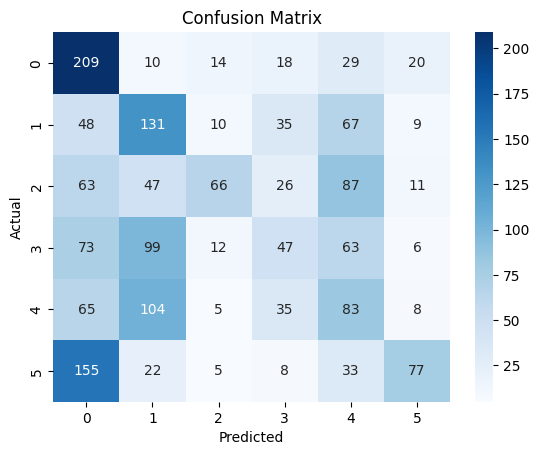

Number of misclassified examples: 1187


In [33]:
conf_matrix = confusion_matrix(all_labels, all_predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

misclassified_indices = np.where(np.array(all_labels) != np.array(all_predictions))[0]
print(f'Number of misclassified examples: {len(misclassified_indices)}')

In [34]:
report3 = classification_report(all_labels, all_predictions, target_names=test_dataset.classes)
print(report3)

              precision    recall  f1-score   support

      Ahegao       0.34      0.70      0.46       300
       Angry       0.32      0.44      0.37       300
       Happy       0.59      0.22      0.32       300
     Neutral       0.28      0.16      0.20       300
         Sad       0.23      0.28      0.25       300
    Surprise       0.59      0.26      0.36       300

    accuracy                           0.34      1800
   macro avg       0.39      0.34      0.33      1800
weighted avg       0.39      0.34      0.33      1800



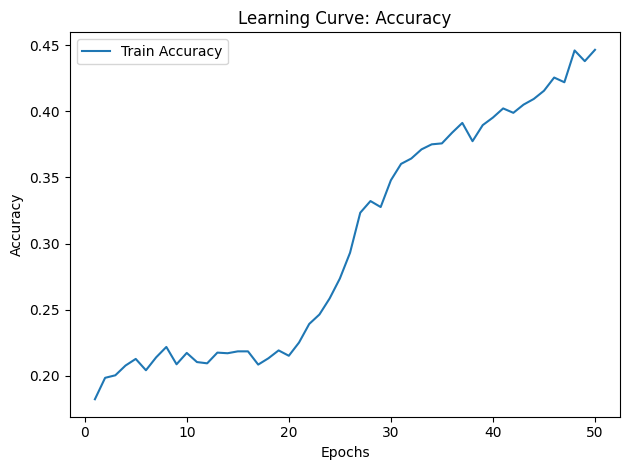

In [35]:
plt.plot(range(1, epochs + 1), training_accuracies, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve: Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Final Analysis in the report